# Image Captioning

Image captioning is a topic that combines LSTM text generation with the computer vision powers of a convolutional neural network.  It is well researched by Andrej Karpathy, now Sr. Director of AI at Tesla I saw this on a deep learning lacture of Stanford.Here we will implement a basic image captioning model.It will not be perfect as we are taking a much smaller dataset for training but it will give decent captions.


In this part, we will use LSTM and CNN to create a basic image captioning system.


We use [InceptionV3](https://arxiv.org/abs/1512.00567) to extract features from the images.

We begin by importing the needed libraries.

In [2]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

We use the following function to nicely format elapsed times.

In [3]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

## Data Needed
Here we are going to use Flicker8k dataset for training this neural network which prodes 8k images having 5 captions. You can use Flicker30k dataset that will give you 30k images and you can genarate more accurate captions. I am using Flicker8K dataset because of processing speed and storage complexity.

Declearing the root folder

In [4]:
root_captioning = "./Project"

### Clean/Build Dataset From Flickr8k

We must pull in the Flickr dataset captions and clean them of extra whitespace, punctuation, and other distractions.

In [5]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flicker8k_text',\
                        'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


The following code displays stats on the data downloaded and processed.

In [6]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum word length of a caption


8092
8763
32


In [7]:
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

Display the count of how many Glove embeddings we have.

In [8]:
len(img)

8091

Read all image names and use the predefined train/test sets.

In [11]:
train_images_path = os.path.join(root_captioning,\
            'Flicker8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flicker8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

Display the size of the train and test sets.

In [12]:
print(len(train_images))
print(len(test_images))

6000
1000


Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption and **stop** token in the generated text will let us know the process is complete.

In [13]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [14]:
len(train_descriptions)

6000

## Choosing Transfer Learning
Here we are going to use two neural networks that we can use via transfer learning. We are going  to use [Glove](https://nlp.stanford.edu/projects/glove/) and InceptionV3 to extract features from the images.Glove is a set of Natural Language Processing (NLP) vectors for common words.InceptionV3 has 2048 features where MobileNet has over 50k. You can use MobileNet if you wish but having 50k features definately will increase processing speed and complexity of the neural networks.

In [15]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

The summary of the chosen image neural network to be transferred is displayed.

In [16]:
encode_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Creating the Training Set

We need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

In [17]:
def encodeImage(img):
  # Resize all images to a standard size (specified by the image 
  # encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for 
  # the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

Now we are goint to genarate our training set which we will do by iterating over every images and we will save it to s pickle file as it takes a while to perform the task.

In [18]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [24:19<00:00,  4.11it/s]


Generating training set took: 0:24:19.53


We must also perform a similar process for the test images.

In [19]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:45<00:00,  3.50it/s]


Generating testing set took: 0:04:45.62


Next, we separate the captions that we will use for training.  There are two sides to this training, the images, and the captions.

In [20]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Words that do not occur very often can be misleading to neural network training.  It is better to remove such words.  Here we remove any words that occur less than ten times.  We display the new reduced size of the vocabulary shrunk.

In [21]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next, we build two lookup tables for this vocabulary. The table **idxtoword** converts index numbers to actual words to index values.  The **wordtoidx** lookup table performs the opposite.

In [22]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [23]:
max_length +=2
print(max_length)

34


## Using a Data Generator
Here we are going to use data genarator as its not practical to include all the training data to the neural network at once as it will increase much more storage complexity.

In [24]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

### Loading Glove Embeddings

In [25]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:53, 7425.51it/s]

Found 400000 word vectors.


### Building the Neural Network

We build an embedding matrix from Glove.  We will directly copy this matrix to the weight matrix of the neural network.

In [26]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

The matrix dimensions make sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [27]:
embedding_matrix.shape

(1652, 200)

In [28]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [29]:
embedding_dim

200

In [30]:
caption_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [31]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the Neural Network

In [32]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [33]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)
    



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.fit, which supports generators.
2000/2000 [==============================] - 601s 300ms/step - loss: 4.1385


  5%|████                                                                            | 1/20 [10:09<3:13:03, 609.66s/it]

2000/2000 [==============================] - 605s 302ms/step - loss: 3.4299


 10%|████████                                                                        | 2/20 [20:14<3:02:28, 608.24s/it]

2000/2000 [==============================] - 591s 296ms/step - loss: 3.2095


 15%|████████████                                                                    | 3/20 [30:06<2:50:55, 603.28s/it]

2000/2000 [==============================] - 593s 297ms/step - loss: 3.0750


 20%|████████████████                                                                | 4/20 [40:00<2:40:06, 600.43s/it]

2000/2000 [==============================] - 541s 270ms/step - loss: 2.9829


 25%|████████████████████                                                            | 5/20 [49:01<2:25:40, 582.72s/it]

2000/2000 [==============================] - 528s 264ms/step - loss: 2.9095


 30%|████████████████████████                                                        | 6/20 [57:49<2:12:09, 566.36s/it]

2000/2000 [==============================] - 526s 263ms/step - loss: 2.8544


 35%|███████████████████████████▎                                                  | 7/20 [1:06:36<2:00:07, 554.42s/it]

2000/2000 [==============================] - 528s 264ms/step - loss: 2.8065


 40%|███████████████████████████████▏                                              | 8/20 [1:15:24<1:49:18, 546.50s/it]

2000/2000 [==============================] - 529s 265ms/step - loss: 2.7652


 45%|███████████████████████████████████                                           | 9/20 [1:24:14<1:39:16, 541.48s/it]

2000/2000 [==============================] - 541s 270ms/step - loss: 2.7324


 50%|██████████████████████████████████████▌                                      | 10/20 [1:33:14<1:30:13, 541.33s/it]

2000/2000 [==============================] - 527s 263ms/step - loss: 2.7005


 55%|██████████████████████████████████████████▎                                  | 11/20 [1:42:02<1:20:33, 537.04s/it]

2000/2000 [==============================] - 524s 262ms/step - loss: 2.6747


 60%|██████████████████████████████████████████████▏                              | 12/20 [1:50:46<1:11:05, 533.13s/it]

2000/2000 [==============================] - 528s 264ms/step - loss: 2.6522


 65%|██████████████████████████████████████████████████                           | 13/20 [1:59:33<1:02:01, 531.58s/it]

2000/2000 [==============================] - 536s 268ms/step - loss: 2.6285


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [2:08:29<53:17, 532.91s/it]

2000/2000 [==============================] - 539s 270ms/step - loss: 2.6103


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [2:17:29<44:34, 534.89s/it]

2000/2000 [==============================] - 558s 279ms/step - loss: 2.5960


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [2:26:48<36:08, 542.03s/it]

2000/2000 [==============================] - 466s 233ms/step - loss: 2.5787


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [2:34:35<25:58, 519.46s/it]

2000/2000 [==============================] - 458s 229ms/step - loss: 2.5648


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [2:42:13<16:42, 501.16s/it]

2000/2000 [==============================] - 453s 226ms/step - loss: 2.5491


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [2:49:46<08:06, 486.70s/it]

2000/2000 [==============================] - 475s 237ms/step - loss: 2.5411


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:57:41<00:00, 533.07s/it]


1000/1000 [==============================] - 451s 451ms/step - loss: 2.3900
\Training took: 4:26:16.48


## Genarating Captions
Now we should understand the network architechture and what it takes as input and what it gives as output. It takes a photo and a growing caption as input and outputs a fixed length tensor. So will first iterate with a image and the Start token and the network's prediction will be next word of the caption and then will put the image and the sequence of the two word and then the model will predict the next word in the captions. In this way we will iterate for 34 four times as we have our max length caption of 32 in training image and a Start and Stop token. We will stop when our network predicts the Stop token and returns the caption.

In [34]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data from Flicker8k

The caption model performs relatively well on images that are similar to the training set.

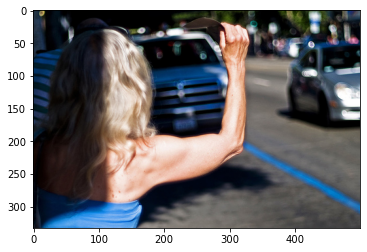

Caption: woman in red shirt and sunglasses is standing next to man in blue shirt


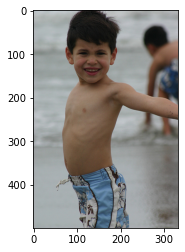

Caption: boy in swim trunks is standing in the water


In [44]:
for z in range(2): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  #print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))

## Evaluating on a picture from Training set

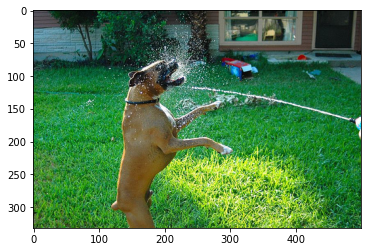

Caption:brown dog is running through the grass


In [42]:
image_path = "./.jpg"
img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
image = encodeImage(img).reshape((1,OUTPUT_DIM))
x = plt.imread("./.jpg")
plt.imshow(x)
plt.show()
print("Caption:{}".format(generateCaption(image)))

## Trying on my own image

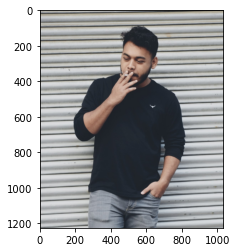

Caption:man in blue shirt and jeans is standing on the sidewalk


In [57]:
image_path = "./my_image.jpg"
img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
image = encodeImage(img).reshape((1,OUTPUT_DIM))
x = plt.imread(image_path)
plt.imshow(x)
plt.show()
print("Caption:{}".format(generateCaption(image)))